In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import altair as alt
import time
import sklearn
import warnings
import pickle

warnings.filterwarnings(action='ignore', category=FutureWarning)

pd.__version__, sklearn.__version__

('2.1.1', '1.3.1')

In [2]:
SCRATCH_DIR = "/scratch/siads696f23_class_root/siads696f23_class/psollars"

# For local dev
SCRATCH_DIR = "./../data"

In [3]:
# Checkpoint
consolidated_df = pd.read_parquet(f"{SCRATCH_DIR}/consolidated_features_2019.parquet")

list(consolidated_df.columns)

['Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'CRSDepTime',
 'CRSArrTime',
 'CRSElapsedTime',
 'Distance',
 'DistanceGroup',
 'YEAR MFR',
 'HORSEPOWER',
 'THRUST',
 'NO-SEATS',
 'Origin_LATITUDE',
 'Origin_LONGITUDE',
 'Dest_LATITUDE',
 'Dest_LONGITUDE',
 'Reporting_Airline',
 'Tail_Number',
 'Origin',
 'Dest',
 'TYPE REGISTRANT',
 'NAME',
 'CERTIFICATION',
 'TYPE ENGINE',
 'STATUS CODE',
 'MFR',
 'MODEL',
 'TYPE',
 'MFR_aircraft',
 'MODEL_aircraft',
 'TYPE-ENG',
 'BUILD-CERT-IND',
 'Origin_DISPLAY_AIRPORT_NAME',
 'Origin_DISPLAY_AIRPORT_CITY_NAME_FULL',
 'Dest_DISPLAY_AIRPORT_NAME',
 'Dest_DISPLAY_AIRPORT_CITY_NAME_FULL',
 'DepDel15',
 'ArrDel15',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay']

In [4]:
num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    # "DistanceGroup",
    "YEAR MFR",
    # "HORSEPOWER",
    # "THRUST",
    # "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    "Reporting_Airline",
    # "Tail_Number",
    "Origin",
    "Dest",
    # "TYPE REGISTRANT",
    # "NAME",
    # "CERTIFICATION",
    # "TYPE ENGINE",
    # "STATUS CODE",
    # "MFR",
    # "MODEL",
    # "TYPE",
    # "MFR_aircraft",
    # "MODEL_aircraft",
    # "TYPE-ENG",
    #
    "DepDel15",
    "ArrDel15",
    # "CarrierDelay",
    # "WeatherDelay",
    # "NASDelay",
    # "SecurityDelay",
    # "LateAircraftDelay",
]

In [5]:
num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "YEAR MFR",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    "Reporting_Airline",
    "Origin",
    "Dest",
    # convert these to "delayed"
    "DepDel15",
    "ArrDel15",
]


delay_df = consolidated_df[num_cols + cat_cols].copy()

# If the flight is delayed on departure or arrival, consider it delayed overall
delay_df["delayed"] = (delay_df["DepDel15"].eq(1)) | (delay_df["ArrDel15"].eq(1))

delay_df = delay_df.drop(columns=["DepDel15", "ArrDel15"], axis=1)

delay_df = delay_df.dropna(how=("any"), axis="index")

# Redefine this variable for the rest of the notebook
cat_cols = ["Reporting_Airline", "Origin", "Dest"]

delay_df.value_counts("delayed")
# False    7074065
# True       53021

delayed
False    5372372
True     1588465
Name: count, dtype: int64

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer


start_time = time.time()


X = delay_df.drop("delayed", axis=1)
y = delay_df["delayed"]


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        # ("cat", OneHotEncoder(), cat_cols),
        ("cat", OrdinalEncoder(), cat_cols),
    ]
)

X_transformed = preprocessor.fit_transform(X)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 33.7355 seconds


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42
)

In [33]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours


start_time = time.time()

# 'not minority': resample all classes but the minority class;
# smote = SMOTE(sampling_strategy="not minority", random_state=42)

# The SMOTE configuration can be set as a SMOTE object via the “smote” argument, 
# and the ENN configuration can be set via the EditedNearestNeighbours object 
# via the “enn” argument. SMOTE defaults to balancing the distribution, 
# followed by ENN that by default removes misclassified examples from all classes.

# We could change the ENN to only remove examples from the majority class by setting the “enn” argument 
# to an EditedNearestNeighbours instance with sampling_strategy argument set to ‘majority‘.
smote = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'), n_jobs=-1)
X_res, y_res = smote.fit_resample(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 60482.8906 seconds


In [34]:
with open(f"{SCRATCH_DIR}/15_delays_2019_X_res_smoteenn.pkl", "wb") as f:
    pickle.dump(X_res, f)

with open(f"{SCRATCH_DIR}/15_delays_2019_y_res_smoteenn.pkl", "wb") as f:
    pickle.dump(y_res, f)

# with open(f"{SCRATCH_DIR}/15_delays_2019_X_res_auto.pkl", "rb") as f:
#     X_res = pickle.load(f)

# with open(f"{SCRATCH_DIR}/15_delays_2019_y_res_auto.pkl", "rb") as f:
#     y_res = pickle.load(f)

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score
import xgboost as xgb


def fit_grid_search_xg_boost(fit_X_train, fit_y_train):
    print(">>>", sum(fit_y_train == 0) / sum(fit_y_train == 1))

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        # Handle imbalance
        scale_pos_weight=sum(fit_y_train == 0) / sum(fit_y_train == 1),
    )

    f_score_half = make_scorer(fbeta_score, beta=0.5)
    f_score_one = make_scorer(fbeta_score, beta=1)
    f_score_two = make_scorer(fbeta_score, beta=2)

    grid_search = GridSearchCV(
        estimator=xgb_clf,
        param_grid={
            "learning_rate": [0.1],  # , 0.2, 0.3],
            "max_depth": [10],  # [5, 7, 10],
            "n_estimators": [150],  # , 250, 500],
            "subsample": [0.7],  # [0.6, 0.7, 0.8],
            "colsample_bytree": [0.7],  # [0.6, 0.7, 0.8],
            "scoring": [f_score_half, f_score_one, f_score_two],
        },
        # scoring=scorer, # "average_precision",  # AUC-PR
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    return grid_search

In [36]:
start_time = time.time()

model = fit_grid_search_xg_boost(X_res, y_res)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

>>> 0.46934490058126305


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if i

Elapsed time: 817.1979 seconds


In [37]:
# Checkpoint on the xgboost model

with open(f"{SCRATCH_DIR}/15_all_delays_xgboost_smote_smoteenn.pkl", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/15_all_delays_xgboost_smote.pkl", "rb") as f:
#     model = pickle.load(f)

# Model Evaluation

In [38]:
model.best_estimator_, model.best_params_

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.1, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=150,
               n_jobs=None, num_parallel_tree=None, random_state=None, ...),
 {'colsample_bytree': 0.7,
  'learning_rate': 0.1,
  'max_depth': 10,
  'n_estimators': 150,
  'scoring': make_scorer(fbeta_score, beta=0.5),
  'subsample': 0.7})

In [39]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    precision_recall_curve,
)

y_pred = model.predict(X_test)

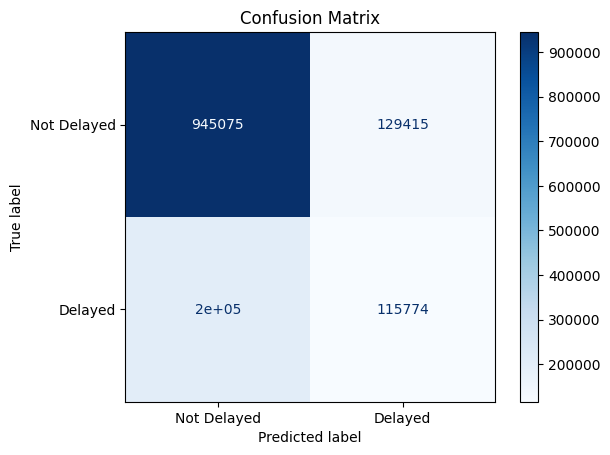

In [40]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Delayed", "Delayed"]
).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [41]:
cm

# XGBoost
# array([[1225409,  182135],
#        [   2756,    7707]])

# Random Forest
# array([[1407521,      23],
#        [  10375,      88]])

array([[945075, 129415],
       [201904, 115774]])

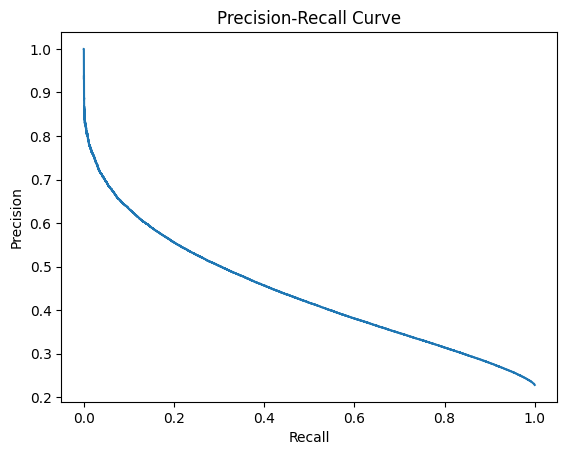

In [42]:
y_scores = model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [43]:
from sklearn.metrics import roc_auc_score


y_pred_proba = model.best_estimator_.predict_proba(X_test)

ra_score = roc_auc_score(y_test, y_pred, average="macro", multi_class="ovr")

# xgboost
# 0.803598235336136

# random forest
# 0.5041971245888275

ra_score

0.6219975088613385

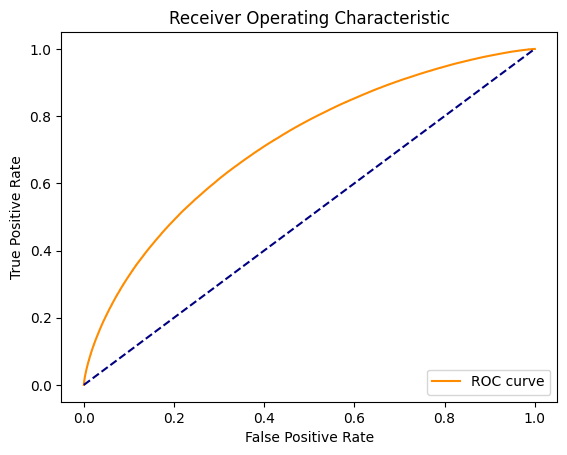

In [44]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [46]:
metrics_scores = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
}

df_metrics = pd.DataFrame(list(metrics_scores.items()), columns=["Metric", "Score"])

base = alt.Chart(df_metrics).encode(
    y=alt.Y("Metric:N", axis=alt.Axis(title="Metric")),
    x=alt.X("Score:Q", axis=alt.Axis(title="Score"), scale=alt.Scale(domain=[0, 1])),
)

bar = base.mark_bar().encode(
    color=alt.Color("Metric:N", legend=None), text=alt.Text("Score:Q", format=".2f")
)

text = base.mark_text(
    align="right",
    baseline="middle",
    color="white",
    dx=-10,
).encode(text=alt.Text("Score:Q", format=".2f"))

chart = (
    (bar + text)
    .properties(title="Evaluation Metrics", width=600, height=300)
    .configure_axis(labelFontSize=12, titleFontSize=14)
)

chart

alt.LayerChart(...)